<a href="https://colab.research.google.com/github/seanyoungsean/DSAI/blob/main/CardiovascularDiseasePrediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import requests as req
import io

import plotly.graph_objects as go # Generate Graphs
from plotly.subplots import make_subplots #To Create Subplots

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#from google.colab import drive

In [2]:
url = "https://raw.githubusercontent.com/seanyoungsean/DSAI/main/cardio_train.csv" # Make sure the url is the raw version of the file on GitHub
download = req.get(url).content
data = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=";",index_col= 'id')

Features:

1. Age | Objective Feature | age | int (days)
2. Height | Objective Feature | height | int (cm) |
3. Weight | Objective Feature | weight | float (kg) |
4. Gender | Objective Feature | gender | categorical code | 1: Female, 2: Male
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

# **1) Basic Exploration**

In [3]:
data

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
0      18393       2     168    62.0    110     80            1     1      0   
1      20228       1     156    85.0    140     90            3     1      0   
2      18857       1     165    64.0    130     70            3     1      0   
3      17623       2     169    82.0    150    100            1     1      0   
4      17474       1     156    56.0    100     60            1     1      0   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
99993  19240       2     168    76.0    120     80            1     1      1   
99995  22601       1     158   126.0    140     90            2     2      0   
99996  19066       2     183   105.0    180     90            3     1      0   
99998  22431       1     163    72.0    135     80            1     2      0   
99999  20540       1     170    72.0    120     80            2     1      0   

       alco  active  cardio  
id                           
0         0       1       0  
1         0       1       1  
2         0       0       1  
3         0       1       1  
4         0       0       0  
...     ...     ...     ...  
99993     0       1       0  
99995     0       1       1  
99996     1       0       1  
99998     0       0       1  
99999     0       1       0  

[70000 rows x 12 columns]

In [4]:
print("(Rows, columns): " + str(data.shape))
data.columns 

(Rows, columns): (70000, 12)


Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [5]:
data.nunique(axis=0)# returns the number of unique values for each variable.

age            8076
gender            2
height          109
weight          287
ap_hi           153
ap_lo           157
cholesterol       3
gluc              3
smoke             2
alco              2
active            2
cardio            2
dtype: int64

In [6]:
duplicate_sum = data.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Duplicates Rows in Dataset are : 24


In [7]:
data.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(data.shape[0], data.shape[1]))

Total 69976 datapoints remaining with 12 features


if a column contains continuous values then it will have good quantity of Unique Values.
Taking 25 as that threshold

In [8]:
Continuous_features = [feature for feature in data.columns if len(data[feature].unique())>25]
print('Continuous Values are : {}'.format(Continuous_features))

Continuous Values are : ['age', 'height', 'weight', 'ap_hi', 'ap_lo']


In [9]:
data[Continuous_features].head()

age  height  weight  ap_hi  ap_lo
id                                     
0   18393     168    62.0    110     80
1   20228     156    85.0    140     90
2   18857     165    64.0    130     70
3   17623     169    82.0    150    100
4   17474     156    56.0    100     60

In [10]:
#summarizes the count, mean, standard deviation, min, and max for numeric variables.
data[Continuous_features].describe()

age        height        weight         ap_hi         ap_lo
count  69976.000000  69976.000000  69976.000000  69976.000000  69976.000000
mean   19468.950126    164.359152     74.208519    128.820453     96.636261
std     2467.374620      8.211218     14.397211    154.037729    188.504581
min    10798.000000     55.000000     10.000000   -150.000000    -70.000000
25%    17664.000000    159.000000     65.000000    120.000000     80.000000
50%    19703.000000    165.000000     72.000000    120.000000     80.000000
75%    21327.000000    170.000000     82.000000    140.000000     90.000000
max    23713.000000    250.000000    200.000000  16020.000000  11000.000000

In [11]:
# Display the Missing Values

print(data.isna().sum())

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [12]:
data['cardio'].value_counts()

0    35004
1    34972
Name: cardio, dtype: int64

# **2) Preparing dataset & Data Analysis**

## **2.1) Cleaning dataset**

In [13]:
fig = go.Figure()

fig.add_trace(go.Box(x=data['height'], name = 'Height', boxpoints='outliers',))
fig.add_trace(go.Box(x=data['weight'], name = 'Weight', boxpoints='outliers',))

fig.update_layout(title_text="Box Plot for Weight and Height with Outliers")
fig.show()

In [89]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Height Distribution", "Weight Distribution"))

histograms = [
    [
        go.Histogram(x=data['height'], name = 'Height'),
        go.Histogram(x=data['weight'], name = 'Weight')
    ]
]

for row in range(len(histograms)):
  for col, histogram in enumerate(histograms[row]):
    fig.append_trace(histogram, row=row+1, col=col+1)
    fig.update_xaxes(title_text=histogram.name, row=row+1, col=col+1)
    fig.update_yaxes(title_text="Total Count", row=row+1, col=col+1)

fig.update_layout(title_text="Histograph", height=700)
fig.show()

In [15]:
def outliers(data_out, drop = False):
    for each_feature in data_out.columns:
        feature_data = data_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))
outliers(data[['height', 'weight']])

For the feature height, No of Outliers is 519
For the feature weight, No of Outliers is 1819


That's good quality of data that we'll gonna lose.
Transforming variables can also eliminate outliers. Natural log of a value reduces the variation caused by extreme values

In [16]:
outline_free_df = data.copy()
outline_free_df[['height', 'weight']] = np.log(outline_free_df[['height', 'weight']])
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 484
For the feature weight, No of Outliers is 1174


In [17]:
outline_free_df = outline_free_df[(outline_free_df['weight'] > outline_free_df['weight'].quantile(0.005)) & (outline_free_df['weight'] < outline_free_df['weight'].quantile(0.995))]
outline_free_df = outline_free_df[(outline_free_df['height'] > outline_free_df['height'].quantile(0.005)) & (outline_free_df['height'] < outline_free_df['height'].quantile(0.995))]
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 0
For the feature weight, No of Outliers is 349


let's get rid of ap_hi and ap_lo values that are negative

In [18]:
outline_free_df = outline_free_df[outline_free_df['ap_lo']>=0]
outline_free_df = outline_free_df[outline_free_df['ap_hi']>=0]

In [19]:
print('There are total {} observations where ap_hi < ap_lo'.format(len(outline_free_df[outline_free_df['ap_hi'] < outline_free_df['ap_lo']])))

There are total 1182 observations where ap_hi < ap_lo


In [20]:
cleaned_data = outline_free_df[outline_free_df['ap_hi'] >= outline_free_df['ap_lo']].reset_index(drop=True)
print('Total observations preserved : {}'.format(len(cleaned_data)))

Total observations preserved : 67156


 the highest pressure recorded in an individual was 370/360.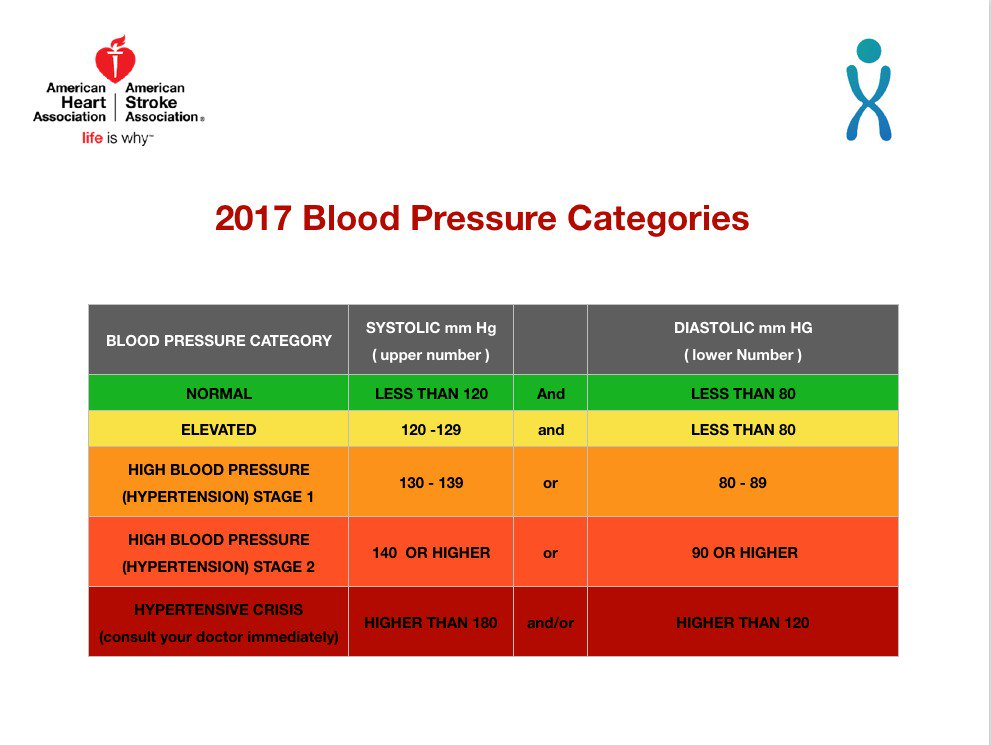

safe to assume some threshold let say, 250 and 200 for ap_hi and ap_lo respectively as upperbound.
Values after that will be dropped as outliers

In [21]:
print('As per our assumptions we have total {} outliers'.format(len(cleaned_data[(cleaned_data["ap_hi"]>250) | (cleaned_data["ap_lo"]>200)])))

As per our assumptions we have total 38 outliers


In [22]:
cleaned_data = cleaned_data[(cleaned_data["ap_hi"]<=250) & (cleaned_data["ap_lo"]<=200)]

In [23]:
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], cleaned_data.shape[1]))

Total 67118 datapoints remaining with 12 features


We have Age in Days. Let's do some wrangling and and Age of person in Years

In [24]:
cleaned_data.head()

age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2  5.123964  4.127134    110     80            1     1      0   
1  20228       1  5.049856  4.442651    140     90            3     1      0   
2  18857       1  5.105945  4.158883    130     70            3     1      0   
3  17623       2  5.129899  4.406719    150    100            1     1      0   
4  17474       1  5.049856  4.025352    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [25]:
#data['age'] = round(data['age']/365, 2)
cleaned_data['age'] = cleaned_data['age'].div(365).apply(lambda x: int(x))

In [91]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=cleaned_data['age'], name = 'Age'))

fig.update_layout(title_text="Age Distribution", height=600)
fig.show()



*   Most of the people in dataset belongs to 49 to 60 age group.
*   We have an outlier with age as 29 (smallest value) but let's ignore it
*   Maximum age in our Dataset is 64



In [27]:
duplicate_sum = cleaned_data.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Duplicates Rows in Dataset are : 3180


In [28]:
duplicated = cleaned_data[cleaned_data.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['gender', 'height', 'weight'], ascending= False)
duplicated.head()

age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  \
22272   57       2  5.192957  4.605170    120     80            1     1   
58984   57       2  5.192957  4.605170    120     80            1     1   
9953    40       2  5.192957  4.382027    120     80            1     1   
20350   56       2  5.192957  4.382027    150     90            1     1   
28371   56       2  5.192957  4.382027    150     90            1     1   

       smoke  alco  active  cardio  
22272      0     0       1       0  
58984      0     0       1       0  
9953       0     0       1       0  
20350      0     0       1       1  
28371      0     0       1       1

In [29]:
cleaned_data.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], cleaned_data.shape[1]))

Total 63938 datapoints remaining with 12 features


In [30]:
fig = go.Figure(data=[go.Bar(x = cleaned_data[cleaned_data['cardio'] == 0]['age'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 0]['age'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleaned_data[cleaned_data['cardio'] == 1]['age'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 1]['age'].value_counts().values, name = 'CVD')]
               )

fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text="Distribution of Age groups grouped by Target Value", 
                  yaxis=dict(title='Total Count', titlefont_size=16, tickfont_size=14,),     
                  xaxis=dict(title='Age', titlefont_size=16, tickfont_size=14,)
                  )
fig.show()

In [90]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("CVD Population", "Non CVD Population"), specs=[[{"type": "pie"}, {"type": "pie"}]])

pies = [
    [
        # Age for CVD
        go.Pie(labels=cleaned_data[cleaned_data['cardio'] == 1]['age'].value_counts().index.to_list(),values=cleaned_data[cleaned_data['cardio'] == 1]['age'].value_counts().values),
        # Age for non CVD
        go.Pie(labels=cleaned_data[cleaned_data['cardio'] == 0]['age'].value_counts().index.to_list(),values=cleaned_data[cleaned_data['cardio'] == 0]['age'].value_counts().values)
    ]
]

for row in range(len(pies)):
  for col, pie in enumerate(pies[row]):
    fig.append_trace(pie, row+1, col+1)
    fig.update_layout(template="plotly_white")
    fig.data[col].marker.line.color = 'rgb(255, 255, 255)'
    fig.data[col].marker.line.width = 2
    fig.update_traces(textposition='inside')

fig.update_layout(title_text="Age Distribution", height=600)
fig.show()

*  From Pie charts it's clear that no age group dominates Non CVD or CVD portion i.e. Age groups are uniformly distributed
*  But if you examine bar graph carefully, you get an interesting pattern:
   1.  People with low age groups have lower chance of having CVD  
   2.  After reaching a peak point which is in this case is age group of 53 plot shows a delince shape for Non CVD and Increasing cases of CVD
   3.  This clearly shows People with higher age groups have more chance of having CVD

In [32]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Height Distribution for CVD Population", "Height Distribution for non CVD Population", "Weight Distribution for CVD Population", "Weight Distribution for non CVD Population"))

histograms = [
    {
        'Height': [
            go.Histogram(x=np.exp(cleaned_data[cleaned_data['cardio'] == 1]['height']), name = 'CVD'),
            go.Histogram(x=np.exp(cleaned_data[cleaned_data['cardio'] == 0]['height']), name = 'Non CVD')
        ],
        'Weight': [
            go.Histogram(x=np.exp(cleaned_data[cleaned_data['cardio'] == 1]['weight']), name = 'CVD'),
            go.Histogram(x=np.exp(cleaned_data[cleaned_data['cardio'] == 0]['weight']), name = 'Non CVD')
        ]
    }
]

for row, key in enumerate(histograms[0]):
  for col, histogram in enumerate(histograms[0][key]):
    fig.append_trace(histogram, row=row+1, col=col+1)
    fig.update_xaxes(title_text=key, row=row+1, col=col+1)
    fig.update_yaxes(title_text="Total Count", row=row+1, col=col+1)

fig.show()

Features like Weight and Height are well distribuited for Non - CVD and CVD Population
Nothing much for takeaway

In [33]:
fig = go.Figure(data=[go.Bar(x = cleaned_data[cleaned_data['cardio'] == 0]['ap_hi'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 0]['ap_hi'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleaned_data[cleaned_data['cardio'] == 1]['ap_hi'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 1]['ap_hi'].value_counts().values, name = 'CVD')]
               )

fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text="Distribution of Systolic blood pressure Values grouped by Target Value", 
                  yaxis=dict(title='Total Count',titlefont_size=16,tickfont_size=14,),     
                  xaxis=dict(title='Systolic Blood Pressure Values',titlefont_size=16,tickfont_size=14,)
                  )
fig.show()

In [87]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("CVD Population", "Non CVD Population"), specs=[[{"type": "pie"}, {"type": "pie"}]])

pies = [
    [
        # Systolic blood pressure for CVD
        go.Pie(labels=cleaned_data[cleaned_data['cardio'] == 1]['ap_hi'].value_counts().index.to_list(),values=cleaned_data[cleaned_data['cardio'] == 1]['ap_hi'].value_counts().values),
        # Systolic blood pressure for non CVD
        go.Pie(labels=cleaned_data[cleaned_data['cardio'] == 0]['ap_hi'].value_counts().index.to_list(),values=cleaned_data[cleaned_data['cardio'] == 0]['ap_hi'].value_counts().values)
    ]
]

for row in range(len(pies)):
  for col, pie in enumerate(pies[row]):
    fig.append_trace(pie, row+1, col+1)
    fig.update_layout(template="plotly_white")
    fig.data[col].marker.line.color = 'rgb(255, 255, 255)'
    fig.data[col].marker.line.width = 2
    fig.update_traces(textposition='inside')

fig.update_layout(title_text="Systolic blood pressure", height=600)

fig.show()

By looking over the graph, We can conclude that :
*  Population has highest no of people having 120 mmHg Systolic Blood Pressure
*  If a person is not having CVD, then There's more likely (48.7 %) that he / she has 120 mmHg Systolic Blood Pressure
*  In case of CVD, We can't claim such strong assumption since no Pressure value is dominating the destribution

In [35]:
fig = go.Figure(data=[go.Bar(x = cleaned_data[cleaned_data['cardio'] == 0]['ap_lo'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 0]['ap_lo'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleaned_data[cleaned_data['cardio'] == 1]['ap_lo'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 1]['ap_lo'].value_counts().values, name = 'CVD')]
               )

fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text="Distribution of Diastolic blood pressure Values grouped by Target Value", 
        yaxis=dict(
        title='Total Count',
        titlefont_size=16,
        tickfont_size=14,
    ),     xaxis=dict(
        title='Diastolic Blood Pressure Values',
        titlefont_size=16,
        tickfont_size=14,
    ))
fig.show()

In [92]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("CVD Population", "Non CVD Population"), specs=[[{"type": "pie"}, {"type": "pie"}]])

pies = [
    [
        # Diastolic blood pressure for CVD
        go.Pie(labels=cleaned_data[cleaned_data['cardio'] == 1]['ap_lo'].value_counts().index.to_list(),values=cleaned_data[cleaned_data['cardio'] == 1]['ap_lo'].value_counts().values),
        # Diastolic blood pressure for non CVD
        go.Pie(labels=cleaned_data[cleaned_data['cardio'] == 0]['ap_lo'].value_counts().index.to_list(),values=cleaned_data[cleaned_data['cardio'] == 0]['ap_lo'].value_counts().values) 
    ]
]

for row in range(len(pies)):
  for col, pie in enumerate(pies[row]):
    fig.append_trace(pie, row+1, col+1)
    fig.update_layout(template="plotly_white")
    fig.data[col].marker.line.color = 'rgb(255, 255, 255)'
    fig.data[col].marker.line.width = 2
    fig.update_traces(textposition='inside')

fig.update_layout(title_text="Diastolic blood pressure", height=600)

fig.show()

By looking over the graph, We can conclude that :
*  Population has highest no of people having 80 mmHg Diastolic Blood Pressure
*  If a person is not having CVD, then There's more likely (55.3 %) that he / she has 120 mmHg Daistolic Blood Pressure
*  If a person is having CVD, then There's more likely (42.5 %) that he / she has 120 mmHg Systolic Blood Pressure with second mostly likely case (31.9 %) of having 90mmHg Daistolic Blood Pressure

## **2.2) Categorical Data**

In [37]:
Categorial_features = [feature for feature in cleaned_data.columns if len(cleaned_data[feature].unique())<25]
print('Categorial Values are : {}'.format(Categorial_features))

Categorial Values are : ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


In [38]:
for each_feature in Categorial_features:
    print('No of Categorial Values in Feature {} is {} as {}'.format(each_feature, len(cleaned_data[each_feature].unique()), cleaned_data[each_feature].unique()))

No of Categorial Values in Feature gender is 2 as [2 1]
No of Categorial Values in Feature cholesterol is 3 as [1 3 2]
No of Categorial Values in Feature gluc is 3 as [1 2 3]
No of Categorial Values in Feature smoke is 2 as [0 1]
No of Categorial Values in Feature alco is 2 as [0 1]
No of Categorial Values in Feature active is 2 as [1 0]
No of Categorial Values in Feature cardio is 2 as [0 1]


Let's check counts of features in different relations

In [39]:
fig = go.Figure([go.Pie(labels=['Not Having CVD', 'Having CVD'],values=cleaned_data['cardio'].value_counts().values)])
fig.update_layout(title_text="Pie chart of Target Variable", template="plotly_white")
fig.data[0].marker.line.color = 'rgb(255, 255, 255)'
fig.data[0].marker.line.width = 2
fig.update_traces(hole=.4,)
fig.show()

Clearly it's a balanced dataset

In [78]:
fig = make_subplots(rows=2, cols=3, vertical_spacing=0.3, subplot_titles=("Alcohol Distribution", "Gender Distribution", "Cholesterol Distribution", "Glucose Distribution", "Smoking Distribution", "Fitness Distribution"), specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])

categoricalFigures = [
    [
        go.Pie(labels=['Non Alcoholic', 'Alcoholic'],values=cleaned_data['alco'].value_counts().values, name = 'Alcohol Status'),
        go.Pie(labels=['Female', 'Male'],values=cleaned_data['gender'].value_counts().values, name = 'Gender Status'),
        go.Pie(labels=['Normal', 'Above Normal', 'Well Above Normal'],values=cleaned_data['cholesterol'].value_counts().values, name = 'Cholesterol Level Status'),
    ],
    [
        go.Pie(labels=['Normal', 'Above Normal', 'Well Above Normal'],values=cleaned_data['gluc'].value_counts().values, name = 'Glucose Level Status'),
        go.Pie(labels=['Non Smoker', 'Smoker'],values=cleaned_data['smoke'].value_counts().values, name = 'Smoking Status'),
        go.Pie(labels=['Not Involved in Physical Activites', 'Involved in Physical Activites'],values=cleaned_data['active'].value_counts().values, name = 'Fitness Status')   
    ]
]

for row in range(len(categoricalFigures)):
  for col, categoricalFigure in enumerate(categoricalFigures[row]):
    fig.append_trace(categoricalFigure, row=row+1, col=col+1)

fig.update_traces(hole=.4,)
fig.update_traces(textposition='inside')
fig.update_layout(title_text="Distribution of Various Categorial Values")

fig.show()

Categorial Values are some kind of biased towards a particular value. I don't think we'll get some useful insights from ploting their distribution in CVD and Non CVD

# **3) Feature Engineering**

## **3.1) Adding new column feature**

In [41]:
def BMI(data):
    # we have converted our weight and height via natural log function to reduce outliers
    # We'll calculate inverse of log and then we'll apply the formula of BMI
    return np.exp(data['weight']) / (np.exp(data['height'])/100)**2 

cleaned_data['bmi'] = cleaned_data.apply(BMI, axis=1)

There's a relation bewteen Systolic Diastolic blood pressure that derives pulse rate

In [42]:
def pulse(data):
    return np.subtract(data['ap_hi'], data['ap_lo'])
 
cleaned_data['pulse'] = cleaned_data.apply(pulse, axis=1)

## **3.2) Feature Selection**

Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

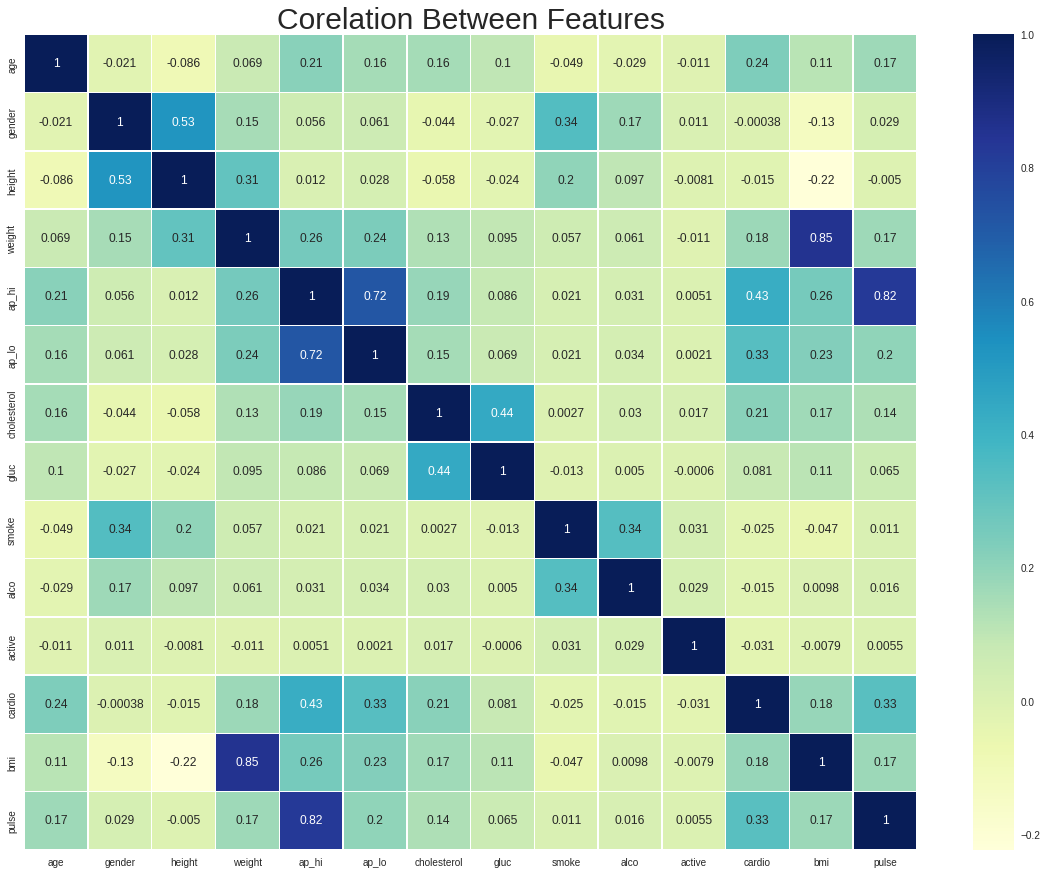

In [43]:
plt.rcParams['figure.figsize'] = (20, 15) 
sns.heatmap(cleaned_data.corr(), annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Corelation Between Features', fontsize = 30)
plt.show()

*  ap_hi has the correlated with quite features but since it has the maximum correlation with Target Value, We can't afford to ignore it
*  Similar case is with pulse and ap_lo

*  Unfortunately our newly formed feature 'bmi' doesn't have good correlation with target + corelates with ap_lo

*  Similar case is with weight

*  'gender' is the least correlated feature + adding correlation with smoke and height

*  Features like height, smoke, alco, active have quite low amount of correlation with target feature

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X1 = cleaned_data.drop(['cardio'], axis=1)  #independent columns
y1 = cleaned_data["cardio"]    #target column i.e price range

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X1,y1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X1.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Columns','Score']  #naming the dataframe columns
print(featureScores.nlargest(8,'Score'))  #print 10 best features

        Columns         Score
4         ap_hi  26117.709466
12        pulse  21704.651033
5         ap_lo   8384.526310
0           age   3158.823026
11          bmi   1927.537565
6   cholesterol   1002.710339
7          gluc    113.287530
8         smoke     36.018407


Preserving Good data, We'll gonna drop 'bmi', 'weight', 'gluc', 'gender', 'height', 'smoke', 'alco', 'active'

In [45]:
X = cleaned_data.drop(['cardio', 'height', 'weight', 'bmi', 'gluc', 'gender', 'smoke', 'alco', 'active'], axis =1)
Y = cleaned_data['cardio']

In [46]:
#data['gender'] = data['gender'].replace({1: "F", 2: "M"})
cleaned_data

age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  \
0       50       2  5.123964  4.127134    110     80            1     1   
1       55       1  5.049856  4.442651    140     90            3     1   
2       51       1  5.105945  4.158883    130     70            3     1   
3       48       2  5.129899  4.406719    150    100            1     1   
4       47       1  5.049856  4.025352    100     60            1     1   
...    ...     ...       ...       ...    ...    ...          ...   ...   
67150   53       1  5.147494  4.248495    130     90            1     1   
67151   57       1  5.105945  4.382027    150     80            1     1   
67153   52       2  5.209486  4.653960    180     90            3     1   
67154   61       1  5.093750  4.276666    135     80            1     2   
67155   56       1  5.135798  4.276666    120     80            2     1   

       smoke  alco  active  cardio        bmi  pulse  
0          0     0       1       0  21.967120   30.0  
1          0     0       1       1  34.927679   50.0  
2          0     0       0       1  23.507805   60.0  
3          0     0       1       1  28.710479   50.0  
4          0     0       0       0  23.011177   40.0  
...      ...   ...     ...     ...        ...    ...  
67150      0     0       1       1  23.661439   40.0  
67151      0     0       1       1  29.384757   70.0  
67153      0     1       0       1  31.353579   90.0  
67154      0     0       0       1  27.099251   55.0  
67155      0     0       1       0  24.913495   40.0  

[63938 rows x 14 columns]

In [47]:
cleaned_data.describe()

age        gender        height        weight         ap_hi  \
count  63938.000000  63938.000000  63938.000000  63938.000000  63938.000000   
mean      52.852576      1.355845      5.101632      4.291647    126.963167   
std        6.800459      0.478772      0.045891      0.177330     16.928861   
min       29.000000      1.000000      4.983607      3.824284     12.000000   
25%       48.000000      1.000000      5.068904      4.174387    120.000000   
50%       53.000000      1.000000      5.105945      4.276666    120.000000   
75%       58.000000      2.000000      5.135798      4.406719    140.000000   
max       64.000000      2.000000      5.220356      4.820282    240.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  63938.000000  63938.000000  63938.000000  63938.000000  63938.000000   
mean      81.331696      1.379586      1.234477      0.091870      0.055741   
std        9.785138      0.688469      0.580570      0.288845      0.229424   
min        0.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max      182.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio           bmi         pulse  
count  63938.000000  63938.000000  63938.000000  63938.000000  
mean       0.798289      0.506803     27.496191     45.631471  
std        0.401281      0.499958      4.968079     11.996971  
min        0.000000      0.000000     14.609204      0.000000  
25%        1.000000      0.000000     23.875433     40.000000  
50%        1.000000      1.000000     26.543210     40.000000  
75%        1.000000      1.000000     30.367347     50.000000  
max        1.000000      1.000000     56.295740    160.000000

## **3.3) Feature Scaling**

In [48]:
scaler = StandardScaler()
standard_X = scaler.fit_transform(X)

# **4) Machine Learning**

## **4.1) Modelling**

In [49]:
# ravel() flatens the array of (70000,1) to (70000,)
X_train, X_test, y_train, y_test = train_test_split(standard_X, Y, test_size=0.30, random_state=0, shuffle=True)
X

age  ap_hi  ap_lo  cholesterol  pulse
0       50    110     80            1   30.0
1       55    140     90            3   50.0
2       51    130     70            3   60.0
3       48    150    100            1   50.0
4       47    100     60            1   40.0
...    ...    ...    ...          ...    ...
67150   53    130     90            1   40.0
67151   57    150     80            1   70.0
67153   52    180     90            3   90.0
67154   61    135     80            1   55.0
67155   56    120     80            2   40.0

[63938 rows x 5 columns]

## **4.2) Logistic Regression**

In [50]:
# --- Applying Logistic Regression ---
classifier_lr1 = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
classifier_lr1.fit(X_train, y_train)
# --- Predicting the test values ---
y_pred_lr = classifier_lr1.predict(X_test)
# # --- Scoring ---
X

age  ap_hi  ap_lo  cholesterol  pulse
0       50    110     80            1   30.0
1       55    140     90            3   50.0
2       51    130     70            3   60.0
3       48    150    100            1   50.0
4       47    100     60            1   40.0
...    ...    ...    ...          ...    ...
67150   53    130     90            1   40.0
67151   57    150     80            1   70.0
67153   52    180     90            3   90.0
67154   61    135     80            1   55.0
67155   56    120     80            2   40.0

[63938 rows x 5 columns]

In [51]:
# --- LR Accuracy ---
acc_lr = accuracy_score(y_pred_lr, y_test)
pre_lr = precision_score(y_test, y_pred_lr)
print('.:. Logistic Regression Accuracy:'+'\033[1m {:.2f}%'.format(acc_lr*100)+' .:.')

# --- LR Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_lr))
print(precision_score(y_test, y_pred_lr))

.:. Logistic Regression Accuracy: 71.90% .:.

.: Classification Report
*************************
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      9446
           1       0.75      0.67      0.71      9736

    accuracy                           0.72     19182
   macro avg       0.72      0.72      0.72     19182
weighted avg       0.72      0.72      0.72     19182

0.752322340919647



.: Performance Evaluation
**************************


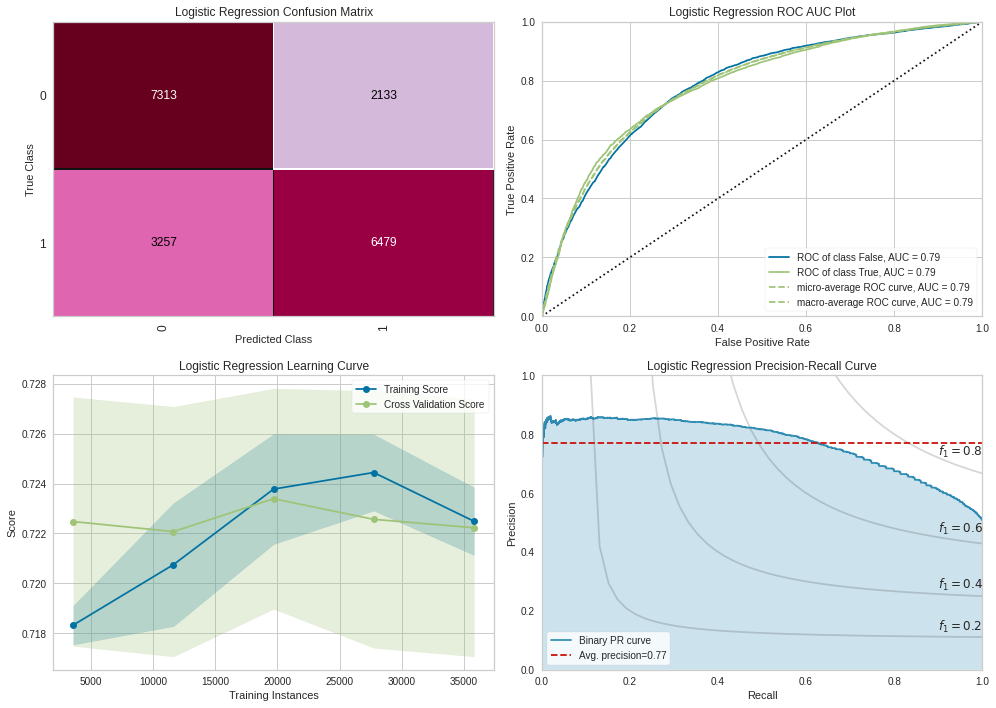

In [52]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- LR Confusion Matrix ---
logmatrix = ConfusionMatrix(classifier_lr1, ax=ax1, cmap='PuRd',
                            title='Logistic Regression Confusion Matrix')
logmatrix.fit(X_train, y_train.values.ravel())
logmatrix.score(X_test, y_test.values.ravel())
logmatrix.finalize()

# --- LR ROC AUC ---
logrocauc = ROCAUC(classifier_lr1, classes=['False', 'True'], ax=ax2,
                   title='Logistic Regression ROC AUC Plot')
logrocauc.fit(X_train, y_train.values.ravel())
logrocauc.score(X_test, y_test.values.ravel())
logrocauc.finalize()

# --- LR Learning Curve ---
loglc = LearningCurve(classifier_lr1, ax=ax3, title='Logistic Regression Learning Curve')
loglc.fit(X_train, y_train.values.ravel())
loglc.finalize()

# --- LR Precision Recall Curve ---
logcurve = PrecisionRecallCurve(classifier_lr1, ax=ax4, ap_score=True, iso_f1_curves=True,
                                title='Logistic Regression Precision-Recall Curve')
logcurve.fit(X_train, y_train.values.ravel())
logcurve.score(X_test, y_test.values.ravel())
logcurve.finalize()

plt.tight_layout();

## **4.3) Random Forest**

In [53]:
# --- Applying Random Forest ---
#RFclassifier = RandomForestClassifier(n_estimators=1000, random_state=1, max_leaf_nodes=20, min_samples_split=15)
RFclassifier = RandomForestClassifier(random_state=24, n_estimators=100, max_leaf_nodes=20, min_samples_split=15, criterion = 'entropy')

RFclassifier.fit(X_train, y_train)
y_pred_RF = RFclassifier.predict(X_test)

In [54]:
# --- Random Forest Accuracy ---
RFAcc = accuracy_score(y_pred_RF, y_test)
RFPre = precision_score(y_test, y_pred_RF)
print('.:. Random Forest Accuracy:'+'\033[1m {:.2f}%'.format(RFAcc*100)+' .:.')

# --- Random FOrest Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_RF))
print(precision_score(y_test, y_pred_RF))

.:. Random Forest Accuracy: 72.09% .:.

.: Classification Report
*************************
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      9446
           1       0.76      0.65      0.70      9736

    accuracy                           0.72     19182
   macro avg       0.73      0.72      0.72     19182
weighted avg       0.73      0.72      0.72     19182

0.7632432432432432



.: Performance Evaluation
**************************


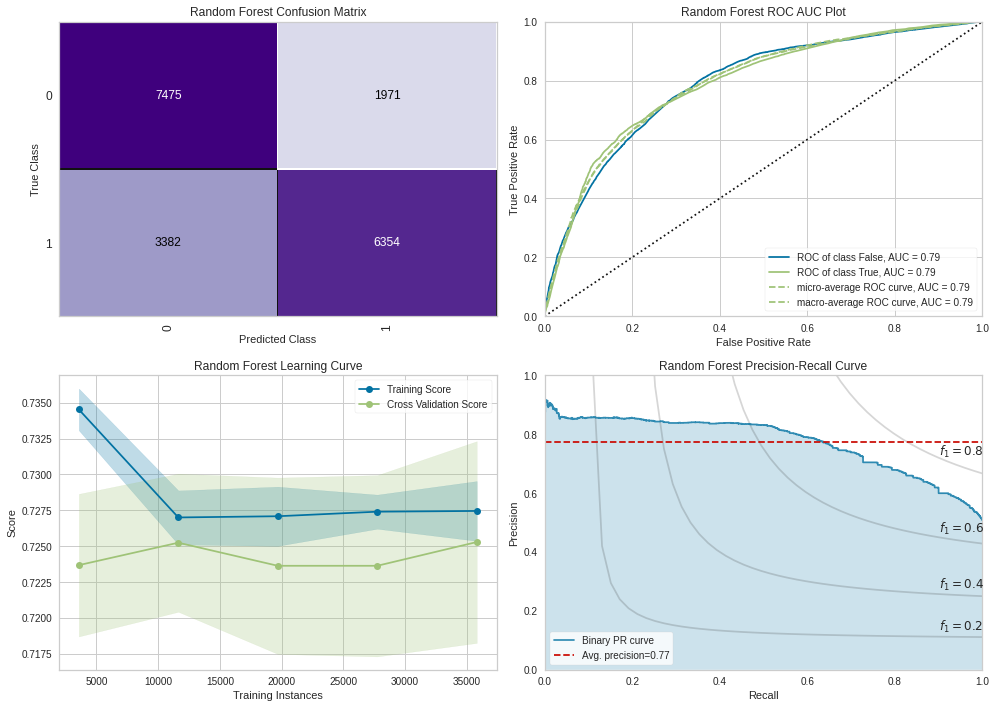

In [55]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- Random Forest Confusion Matrix ---
rfcmatrix = ConfusionMatrix(RFclassifier, ax=ax1, cmap='Purples',
                            title='Random Forest Confusion Matrix')
rfcmatrix.fit(X_train, y_train)
rfcmatrix.score(X_test, y_test)
rfcmatrix.finalize()

# --- Random Forest ROC AUC ---
rccrocauc = ROCAUC(RFclassifier, classes=['False', 'True'], ax=ax2,
                   title='Random Forest ROC AUC Plot')
rccrocauc.fit(X_train, y_train)
rccrocauc.score(X_test, y_test)
rccrocauc.finalize()

# --- Random Forest Learning Curve ---
rcclc = LearningCurve(RFclassifier, ax=ax3, title='Random Forest Learning Curve')
rcclc.fit(X_train, y_train)
rcclc.finalize()

# --- Random Forest Precision Recall Curve ---
rcccurve = PrecisionRecallCurve(RFclassifier, ax=ax4, ap_score=True, iso_f1_curves=True, 
                                title='Random Forest Precision-Recall Curve')
rcccurve.fit(X_train, y_train)
rcccurve.score(X_test, y_test)
rcccurve.finalize()

plt.tight_layout();

# **5) Comparing Models**

## **5.1) Inititial comparision**

In [56]:
# --- Create Accuracy Comparison Table ---
compare = pd.DataFrame({'Model': ['Logistic Regression','Random Forest'], 
                        'Accuracy': [acc_lr*100, RFAcc*100],
                        'Precision': [pre_lr*100, RFPre*100]})

# --- Create Accuracy Comparison Table ---
compare.sort_values(by='Accuracy', ascending=False).style.background_gradient(cmap='PuRd').hide_index().set_properties(**{'font-family': 'Segoe UI'})

## **5.2) Cross-validation** 

### **5.2.1) Using K-Neighbors**

In [57]:
# --- Applying KNN ---
KNNClassifier = KNeighborsClassifier(n_neighbors=3)
KNNClassifier.fit(X_train, y_train)

y_pred_KNN = KNNClassifier.predict(X_test)

In [58]:
# --- KNN Accuracy ---
KNNAcc = accuracy_score(y_pred_KNN, y_test)
KNNPre = precision_score(y_test, y_pred_RF)
print('.:. K-Nearest Neighbour Accuracy:'+'\033[1m {:.2f}%'.format(KNNAcc*100)+' .:.')

# --- KNN Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_KNN))

.:. K-Nearest Neighbour Accuracy: 66.79% .:.

.: Classification Report
*************************
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      9446
           1       0.66      0.71      0.68      9736

    accuracy                           0.67     19182
   macro avg       0.67      0.67      0.67     19182
weighted avg       0.67      0.67      0.67     19182



### **5.2.2) Using Naive Bayes**

In [59]:
# --- Applying Gaussian NB ---
GNBclassifier = GaussianNB(var_smoothing=0.1)
GNBclassifier.fit(X_train, y_train)

y_pred_GNB = GNBclassifier.predict(X_test)

In [60]:
# --- GNB Accuracy ---
GNBAcc = accuracy_score(y_pred_GNB, y_test)
GNBPre = precision_score(y_test, y_pred_RF)
print('.:. Gaussian Naive Bayes Accuracy:'+'\033[1m {:.2f}%'.format(GNBAcc*100)+' .:.')

# --- GNB Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_GNB))

.:. Gaussian Naive Bayes Accuracy: 71.39% .:.

.: Classification Report
*************************
              precision    recall  f1-score   support

           0       0.67      0.83      0.74      9446
           1       0.79      0.60      0.68      9736

    accuracy                           0.71     19182
   macro avg       0.73      0.72      0.71     19182
weighted avg       0.73      0.71      0.71     19182



## **5.3) Comparison with cross-validation**

In [61]:
# --- Create Accuracy Comparison Table ---
compare = pd.DataFrame({'Model': ['Logistic Regression','Random Forest','K-Nearest Neighbour', 'Gaussian Naive Bayes'], 
                        'Accuracy': [acc_lr*100, RFAcc*100, KNNAcc*100, GNBAcc*100],
                        'Precision': [pre_lr*100, RFPre*100, KNNPre*100, GNBPre*100]})

# --- Create Accuracy Comparison Table ---
print(".:. Cross-Validation")
compare.sort_values(by=['Accuracy', 'Precision'], ascending=[False, False]).style.background_gradient(cmap='PuRd').hide_index().set_properties(**{'font-family': 'Segoe UI'})

.:. Cross-Validation


# **6) User Input Prediction**

In [62]:
# age	ap_hi	ap_lo	cholesterol	pulse
userInput = [{
    "age": 61,
    "ap_hi": 100,
    "ap_lo": 60,
    "cholesterol": 3,
},
{
    "age": 18,
    "ap_hi": 150,
    "ap_lo": 100,
    "cholesterol": 1,
}]

userdf = pd.DataFrame.from_dict(userInput) 

userdf["pulse"] = userdf.apply(pulse, axis=1)

userdf

age  ap_hi  ap_lo  cholesterol  pulse
0   61    100     60            3     40
1   18    150    100            1     50

In [63]:
arr = np.array(userdf.values)
#arr = [testInput]
arr

array([[ 61, 100,  60,   3,  40],
       [ 18, 150, 100,   1,  50]])

In [64]:
user_test = RFclassifier.predict(arr)
user_lr = classifier_lr1.predict(arr)
user_test
user_lr

array([1, 1])

In [65]:
user_lr

array([1, 1])